# Laboratorio 5

En este laboratorio, estaremos repasando los conceptos de Atención y Transformadores. Buscaremos acercanos a la implementación del paper ["Attention is All you Need"](https://arxiv.org/abs/1706.03762). Por ello, todas las imagenes que veremos aca son del paper, a menos que se indique lo contrario. 

Al igual que en laboratorios anteriores, para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
#!pip install scikit-image
#!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master
#!pip install matplotlib

In [75]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [76]:
# Seeds
seed_ = 2023
np.random.seed(seed_)

In [77]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [78]:
carne_1 = "21371"
firma_mecanografiada_1 = "Sara Echeverria"
carne_2 = "21289"
firma_mecanografiada_2 = "Ricardo Mendez"

In [79]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

### Introducción

Similar al modelo Seq2Seq, el modelo de Transformer no usará recurrencias, ni tampoco capaz convolucionales. En su lugar, el modelo está hecho meramente con capaz lineales, mecanismos de atención y normalización.

Una de las variantes más populares de los Transformadores es BERT (Bidrectional Encoder Representations from Transformers) y versiones pre-entrenadas de BERT que son comunmente usadas para sistituir capaz de embedding (y otras cosas más) en modelos de NLP.

Cabe descatar algunas diferencias entre la implentación que haremos y la del paper:

* Usaremos un positional encoding aprendido y no uno estático
* Usaremos un optimizador estándar Adam con un learning rate estático, en lugar de uno con warm-up y cool-down 
* No usaremos label smoothing

Se consideran estas modificaciones a finalidad de hacer una implementación que se acerque a como BERT suele ser seteado.

Consideren que para esta parte estaremos usando el mismo dataset que usamos para la segunda parte del laboratorio pasado. Por ende, sugiero que usen el mismo venv que usaron para esa parte.

**Créditos:** Esta parte de este laboratorio está tomado y basado en uno de los repositorios de Ben Trevett

### Preparando la Data

Como la otra vez, volvemos a empezar importando las librerías necesarias. Así también seteamos la Seed para asegurar que las calificaciones sean consistentes. 

Despues, al igual que en el lab anterior, haremos el tokenizador. Así mismo definimos mismo Field de la ultima vez con la diferencia menor que ahora estaremos pasando batches de datos, por ende usaremos el parámetr "batch_first=True"

Despues cargaremos el mismo dataset de la ultima vez "Multi30K" para construir nuestro vocabulario. Donde se cargan los sets de `train_data`, `valid_data` y `test_data`, hagan los cambios necesarios para cargar los datos como lo hicieron la última vez. **Siéntase libre de hacer copy-paste de lo que hicieron en el lab4.** 

Finalmente, definiremos el `device` con el que estaremos trabajando. **Se recomienda usar CUDA**. Por otro lado, recuerden que tienen **disponible el laboratorio del CIT-411** para que lo usen en el período de clase de los días lunes. En las máquinas de este laboratorio pueden usar CUDA y deberían ser más rápidas que los tiempos mostrados en este Notebook.

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k

train_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
val_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
test_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update the URLs in the Multi30k module
Multi30k.urls = (train_url, val_url, test_url)

from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [81]:
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
torch.cuda.manual_seed(seed_)
torch.backends.cudnn.deterministic = True

In [82]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [83]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [84]:
# Noten el uso de batch_first
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [85]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG),
                                                    root = '/lab/datasets/Multi30k')

In [86]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [87]:
# Se recomienda el uso de CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [88]:
# Definimos el tamaño del batch y creamos iteradores
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

### Construyendo el Modelo

A continuación, construiremos el modelo. Al igual que los notebook anteriores, se compone de un *encoder* y un *decoder*, con el encoder *codificando* la oración de entrada/fuente (en alemán) en *vector de contexto* y el decpder luego *decodificando* este vector de contexto para generar nuestra oración de salida/objetivo (en inglés)

#### Encoder
El codificador de Transformer no intenta comprimir la oración fuente completa, $X = (x_1, ... ,x_n)$, en un solo vector de contexto, $z$. En su lugar, produce una secuencia de vectores de contexto, $Z = (z_1, ... , z_n)$. Entonces, si nuestra secuencia de entrada fuera de 5 tokens, tendríamos $Z = (z_1, z_2, z_3, z_4, z_5)$.

¿Por qué llamamos a esto una secuencia de vectores de contexto y no una secuencia de estados ocultos? Un estado oculto en el tiempo $t$ en un RNN solo ha visto tokens $x_t$ y todos los tokens anteriores. Sin embargo, cada vector de contexto aquí ha visto todos los tokens en todas las posiciones dentro de la secuencia de entrada.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-encoder.png)

Primero, los tokens se pasan a través de una capa de embedding estándar. Luego, como el modelo no tiene recurrencia, no tiene idea del orden de los tokens dentro de la secuencia. Resolvemos esto usando una segunda capa de embedding llamada *capa de positional embedding*. Esta es una capa de embedding estándar donde la entrada no es el token en sí, sino la posición del token dentro de la secuencia, comenzando con el primer token, el token `<sos>` (inicio de secuencia), en la posición 0. La posición embeddida tiene un tamaño de "vocabulario" de 100, lo que significa que nuestro modelo puede aceptar oraciones de hasta 100 tokens de largo. Esto se puede aumentar si queremos manejar oraciones más largas.

La implementación original de Transformer del documento Attention is All You Need no aprende embedding posicionales. En su lugar, utiliza una incrustación estática fija. Las arquitecturas modernas de Transformer, como BERT, usan embedding posicionales en su lugar, por lo que lo haremos asi en este laboratorio. Consulte [esta](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) sección para obtener más información sobre las positional embedding utilizadas en el modelo Transformer original.

A continuación, los embedding de tokens y posicionales se suman por elementos para obtener un vector que contiene información sobre el token y también su posición en la secuencia. Sin embargo, antes de que se sumen, las incrustaciones de tokens se multiplican por un factor de escala que es $\sqrt{d_{model}}$, donde $d_{model}$ es el tamaño del hidden state, `hid_dim`. Esto supuestamente reduce la variación en las incorporaciones y el modelo es difícil de entrenar de manera confiable sin este factor de escala. A continuación, se aplica el dropout a las embeddings combinadas.

Las embedding combinadas luego se pasan a través de $N$ *capas de encoder* para obtener $Z$, que luego se van de output y puede ser utilizado por el decoder.

La máscara fuente, `src_mask`, tiene simplemente la misma forma que la oración fuente pero tiene un valor de 1 cuando el token en la oración fuente no es un token `<pad>` y 0 cuando es un `<pad>`. simbólico. Esto se usa en las capas del encoder para enmascarar los mecanismos de atención de múltiples cabezas, que se usan para calcular y aplicar atención sobre la oración fuente, por lo que el modelo no presta atención a los tokens `<pad>`, que no contienen información útil.

In [89]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

### Capa de Encoder

Las capas del encoder son donde está contenida toda la "carne" del codificador. Primero pasamos la oración fuente y su máscara a la *capa de atención de múltiples cabezas*, luego realizamos el dropout, aplicamos una conexión residual y la pasamos a través de una [Normalización de capa](https://arxiv.org/abs/1607.06450 ). Luego lo pasamos a través de una capa de *position-wise feedforward* y luego, nuevamente, aplicamos dropout, una conexión residual y luego la normalización de la capa para obtener la salida de esta capa que se alimenta a la siguiente capa. Los parámetros no se comparten entre capas.

La capa encoder utiliza la capa de atención de múltiples cabezas para prestar atención a la oración fuente, es decir, está calculando y aplicando atención sobre sí misma en lugar de sobre otra secuencia, por lo que la llamamos *autoatención*.

[Este](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) artículo entra en más detalles sobre la capa normalización, pero la esencia es que normaliza los valores de las features, es decir, a través de la hidden dimension, por lo que cada característica tiene una media de 0 y una desviación estándar de 1. Esto permite a las redes neuronales con una mayor cantidad de capas, como el Transformador , el poder entrear más fácil.

In [90]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection y layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Multi Head Attention Layer
Uno de los conceptos clave y novedosos introducidos por el artículo de Transformer es la *capa de atención de múltiples cabezas*.


![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-attention.png)

La atención se puede considerar como *querys*, *keys* y *values*, donde la query se usa con la key para obtener un vector de atención (generalmente el resultado de una operación *softmax* y tiene todos los values entre 0 y 1 que suma a 1) que luego se usa para obtener una suma ponderada de los values.

El transformador utiliza *atención de producto escalar "escalado"*, donde la query y la key se combinan tomando el producto escalar entre ellos, luego aplicando la operación softmax y escalando por $d_k$ antes de finalmente multiplicar por el value. $d_k$ que es la *dimensión de la cabeza*, `head_dim`, que explicaremos más adelante.

$$ \text{Atención}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

Esto es similar a la *atención estándar del producto escalar* pero se escala por $d_k$, que según el documento se usa para evitar que los resultados de los productos escalares crezcan demasiado, lo que hace que los gradientes se vuelvan demasiado pequeños.

Sin embargo, la atención del producto punto escalado no se aplica simplemente a las querys, keys y values. En lugar de hacer una sola aplicación de atención, las querys, las keys y los valuees tienen su `hid_dim` dividido en $h$ *cabezas* y la atención del producto punto escalado se calcula sobre todas las cabezas en paralelo. Esto significa que en lugar de prestar atención a un concepto por aplicación de atención, prestamos atención a $h$. Luego, volvemos a combinar las cabezas en su forma `hid_dim`, por lo que cada `hid_dim` está potencialmente prestando atención a $h$ conceptos diferentes.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{cabeza}_i = \text{Atención}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ es la capa lineal aplicada al final de la capa de atención de múltiples cabezas, `fc`. $W^Q, W^K, W^V$ son las capas lineales `fc_q`, `fc_k` y `fc_v`.

Recorriendo el módulo, primero calculamos $QW^Q$, $KW^K$ y $VW^V$ con las capas lineales, `fc_q`, `fc_k` y `fc_v`, para obtener `Q`, ` K` y `V`. A continuación, dividimos `hid_dim` de la query, la key y el value en `n_heads` usando `.view` y los permutamos correctamente para que puedan multiplicarse entre sí. Luego calculamos la 'energía' (la atención no normalizada) multiplicando 'Q' y 'K' juntos y escalando por la raíz cuadrada de 'head_dim', que se calcula como 'hid_dim // n_heads'. Luego enmascaramos la energía para que no prestemos atención a ningún elemento de la secuencia que no deberíamos, luego aplicamos el softmax y el dropout. Luego aplicamos la atención a los values caras, `V`, antes de combinar los `n_cabezas`. Finalmente, multiplicamos este $W^O$, representado por `fc_o`.

Note que en nuestra implementación, las longitudes de las keys y los values son siempre los mismos, por lo tanto, cuando la matriz multiplica la salida del softmax, `atención`, con `V`, siempre tendremos tamaños de dimensión válidos para la multiplicación de matrices. Esta multiplicación se lleva a cabo usando `torch.matmul` que, cuando ambos tensores son > bidimensionales, realiza una multiplicación matricial por batches sobre las dos últimas dimensiones de cada tensor. Esta será una **[longitud de query, longitud de key] x [longitud de value, atenuación de cabezal]** multiplicación de matriz por batches sobre el tamaño del batch y cada cabezal que proporciona el **[tamaño de batch, n cabezales, longitud de query, atenuación de cabezal ]** resultado.

Una cosa que parece extraña al principio es que dropout se aplica directamente a la atención. Esto significa que nuestro vector de atención probablemente no sumará 1 y podemos prestar toda la atención a un token, pero la atención sobre ese token se establece en 0 por dropout. Esto nunca se explica, ni siquiera se menciona, en el documento; sin embargo, lo usa la [implementación oficial](https://github.com/tensorflow/tensor2tensor/) y todas las implementaciones de Transformer desde [BERT] (https:// github.com/google-research/bert/).

In [91]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Capa Position-wise Feedforward
El otro bloque principal dentro de la capa del encoder es la *capa de realimentación por posición* o *capa position-wise feedforward*. Es relativamente simple en comparación con la capa de atención multi-head. La entrada se transforma de `hid_dim` a `pf_dim`, donde `pf_dim` suele ser mucho más grande que `hid_dim`. El Transformer original usaba un `hid_dim` de 512 y un `pf_dim` de 2048. La función de activación y dropout de ReLU se aplica antes de que se transforme de nuevo en una representación `hid_dim`.

¿Por qué se usa esto? Desafortunadamente, nunca se explica en el documento.

BERT usa la función de activación [GELU](https://arxiv.org/abs/1606.08415), que se puede usar simplemente cambiando `torch.relu` por `F.gelu`. ¿Por qué usaron GELU? De nuevo, lastimosamente, no se explica.

In [92]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

El objetivo del decoder es tomar la representación codificada de la oración de origen, $Z$, y convertirla en tokens predichos en la oración de destino, $\hat{Y}$. Luego comparamos $\hat{Y}$ con los tokens reales en la oración objetivo, $Y$, para calcular nuestra pérdida, que se usará para calcular los gradientes de nuestros parámetros y luego usamos nuestro optimizador para actualizar nuestros pesos en orden para mejorar nuestras predicciones.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-decoder.png)

El decoder es similar al encoder, sin embargo, ahora tiene dos capas de atención multi-head. Una *capa de atención multi-head enmascarada* sobre la secuencia de destino y una capa de atención multi-head que utiliza la representación del decoder como consulta y la representación del encoder como clave y valor.

El decoder utiliza positional embeddings y las combina, a través de una suma de elementos, con los tokens de destino embeddidos escalados, seguidos de dropout. Nuevamente, nuestras codificaciones posicionales tienen un "vocabulario" de 100, lo que significa que pueden aceptar secuencias de hasta 100 tokens de largo. Esto se puede aumentar si se desea.

Las embeddings combinadas luego se pasan a través de las capas del decodificador $N$, junto con la fuente codificada, `enc_src`, y las máscaras de origen y destino. Considere que la cantidad de capas en el encoder no tiene que ser igual a la cantidad de capas en el decoder, aunque ambas se indican con $N$.

La representación del decoder después de la capa $N^{th}$ se pasa a través de una capa lineal, `fc_out`. En PyTorch, la operación softmax está contenida dentro de nuestra función de pérdida, por lo que no necesitamos usar explícitamente una capa softmax aquí.

Además de usar la máscara de origen, como hicimos en el encoder para evitar que nuestro modelo preste atención a los tokens `<pad>`, también usamos una máscara de destino. Esto se explicará con más detalle en el modelo `Seq2Seq` que encapsula tanto el encoder como el decoder. Como estamos procesando todos los tokens de destino a la vez en paralelo, necesitamos un método para evitar que el decoder "haga trampa" simplemente "mirando" cuál es el siguiente token en la secuencia de destino y emitiéndolo.

Nuestra capa de decoder también genera los valores de atención normalizados para que luego podamos trazarlos y ver a qué está prestando atención nuestro modelo.

In [93]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            layer = DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            self.layers.append(layer)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer
Como se mencionó antes, la capa del decoder es similar a la capa del encoder, excepto que ahora tiene dos capas de atención multi-head, `self_attention` y `encoder_attention`.

El primero realiza la autoatención, como en el encoder, utilizando la representación del decoder en cuanto a query, key y value. A esto le sigue el dropout, la conexión residual y la normalización de capas. Esta capa `self_attention` utiliza la máscara de secuencia de destino, `trg_mask`, para evitar que el decoder "haga trampa" al prestar atención a los tokens que están "por delante" del que está procesando actualmente, ya que procesa todos los tokens en el objetivo. oración en paralelo.

El segundo es cómo alimentamos la oración fuente codificada, `enc_src`, en nuestro decoder. En esta capa de atención de multi-head, las queries son las representaciones del decoder y las keys y los values son las representaciones del encoder. Aquí, la máscara de origen, `src_mask` se usa para evitar que la capa de atención multi-head preste atención a los tokens `<pad>` dentro de la oración de origen. A esto le siguen las capas de dropout, conexión residual y normalización de capas.

Finalmente, pasamos esto a través de la capa de  position-wise feedforward y otra secuencia más de dropout, conexión residual y normalización de capa.

La capa del decoder no presenta ningún concepto nuevo, solo usa el mismo conjunto de capas que el encoder de una manera ligeramente diferente.

In [94]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Modelo Seq2Seq 
Finalmente, tenemos el módulo `Seq2Seq` que encapsula el encoder y decoder, además de manejar la creación de las máscaras.

La máscara de origen se crea comprobando dónde la secuencia de origen no es igual a un token `<pad>`. Es 1 cuando el token no es un token `<pad>` y 0 cuando lo es. Luego se descomprime para que pueda transmitirse correctamente al aplicar la máscara a la `energía`, que tiene la forma **_[tamaño del batch, n cabezas, seq len, seq len]_**.

La máscara de destino es un poco más complicada. Primero, creamos una máscara para los tokens `<pad>`, como hicimos con la máscara fuente. A continuación, creamos una máscara "subsecuente", `trg_sub_mask`, usando `torch.tril`. Esto crea una matriz diagonal donde los elementos por encima de la diagonal serán cero y los elementos por debajo de la diagonal se establecerán en cualquiera que sea el tensor de entrada. En este caso, el tensor de entrada será un tensor lleno de unos. Esto significa que nuestra `trg_sub_mask` se verá así (para un objetivo con 5 tokens):

$$
1  0  0  0  0\\
1  1  0  0  0\\
1  1  1  0  0\\
1  1  1  1  0\\
1  1  1  1  1\\
$$

Esto muestra lo que cada token de destino (fila) puede ver (columna). El primer token de destino tiene una máscara de **_[1, 0, 0, 0, 0]_**, lo que significa que solo puede mirar el primer token de destino. El segundo token de destino tiene una máscara de **_[1, 1, 0, 0, 0]_**, lo que significa que puede ver tanto la primera como la segunda ficha de destino.

A continuación, la máscara "subsecuente" se combina lógicamente con la máscara de relleno, lo que combina las dos máscaras, lo que garantiza que no se pueda atender ni a los tokens posteriores ni a los tokens de relleno. Por ejemplo, si los dos últimos tokens fueran tokens `<pad>`, la máscara se vería así:

$$
1  0  0  0  0\\
1  1  0  0  0\\
1  1  1  0  0\\
1  1  1  0  0\\
1  1  1  0  0\\
$$

Después de crear las máscaras, se utilizan con el encoder y el decoder junto con las oraciones de origen y de destino para obtener nuestra oración de destino predicha, "salida", junto con la atención del decoder sobre la secuencia de origen.

In [95]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

### Entrenamiento
Ahora ya podemos entrenar nuestro modelo, el cual es más pequeño que el modelo usado en el paper original, pero es lo suficientemente robusto.

Luego, vamos a definir nuestro modelo completo sequence-to-sequence.

Después, creamos una función para contar el número de parámetros, notando que esta vez ya estamos hablando de millones de parametros dentro de un modelo.

Más tarde, definimos la forma de iniciar los pesos, usando una técnica conocida como Xavier uniform.

Luego, el optimizador utilizado con un learning rate fijo es declarado. Consideren que el learning rate debe ser inferior a la predeterminada utilizada por Adam o, de lo contrario, el aprendizaje es inestable.

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [24]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [26]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [27]:
model.apply(initialize_weights);

In [28]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [29]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Como queremos que nuestro modelo prediga el token `<eos>` pero no que sea una entrada en nuestro modelo, simplemente cortamos el token `<eos>` del final de la secuencia. De este modo:

$$ \text{Atención}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$


$$
\text{trg} = [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} = [sos, x_1, x_2, x_3]
$$

$x_i$ denota el elemento de secuencia de destino real. Luego ingresamos esto en el modelo para obtener una secuencia predicha que debería predecir el token `<eos>`:

$$
\text{salida} = [y_1, y_2, y_3, eos]
$$

$y_i$ denota el elemento de secuencia de destino predicho. Luego calculamos nuestra pérdida usando el tensor `trg` original con el token `<sos>` cortado del frente, dejando el token `<eos>`:

$$
\text{salida} = [y_1, y_2, y_3, eos]\\
\text{trg[1:]} = [x_1, x_2, x_3, eos]
$$

Luego calculamos nuestras losses y actualizamos nuestros parámetros como es estándar.

In [30]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

El ciclo de evaluación es el mismo que el del entrenamiento pero sin la parte de la graiente y la actualizacion de los parametros

In [31]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
# Una linea para definir el numero de epocas
# N_EPOCHS = 10
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 13m 6s
	Train Loss: 4.227 | Train PPL:  68.522
	 Val. Loss: 3.019 |  Val. PPL:  20.470
Epoch: 02 | Time: 13m 1s
	Train Loss: 2.799 | Train PPL:  16.427
	 Val. Loss: 2.285 |  Val. PPL:   9.824
Epoch: 03 | Time: 13m 50s
	Train Loss: 2.223 | Train PPL:   9.236
	 Val. Loss: 1.961 |  Val. PPL:   7.109
Epoch: 04 | Time: 12m 34s
	Train Loss: 1.875 | Train PPL:   6.523
	 Val. Loss: 1.787 |  Val. PPL:   5.972
Epoch: 05 | Time: 7m 6s
	Train Loss: 1.630 | Train PPL:   5.105
	 Val. Loss: 1.690 |  Val. PPL:   5.419
Epoch: 06 | Time: 6m 49s
	Train Loss: 1.442 | Train PPL:   4.227
	 Val. Loss: 1.652 |  Val. PPL:   5.219
Epoch: 07 | Time: 6m 50s
	Train Loss: 1.288 | Train PPL:   3.624
	 Val. Loss: 1.616 |  Val. PPL:   5.031
Epoch: 08 | Time: 6m 46s
	Train Loss: 1.164 | Train PPL:   3.202
	 Val. Loss: 1.603 |  Val. PPL:   4.968
Epoch: 09 | Time: 6m 48s
	Train Loss: 1.056 | Train PPL:   2.874
	 Val. Loss: 1.614 |  Val. PPL:   5.020
Epoch: 10 | Time: 6m 45s
	Train Loss: 0.961 | Train PP

In [96]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.666 | Test PPL:   5.292 |


**NB:** La perplejidad (PPL) es una medida utilizada para evaluar la efectividad de un modelo de lenguaje al predecir una secuencia de palabras. Cuantifica qué tan bien el modelo predice la siguiente palabra en una secuencia basada en las palabras anteriores. Una perplejidad más baja indica que el modelo tiene más certeza y precisión en sus predicciones, lo que refleja una mejor comprensión del lenguaje. Por otro lado, una perplejidad más alta sugiere que el modelo tiene menos certeza y le cuesta predecir la siguiente palabra con precisión. La perplejidad se utiliza comúnmente en el procesamiento del lenguaje natural para evaluar la calidad de los modelos de lenguaje, especialmente en tareas como la traducción automática y la generación de texto.

In [97]:
with tick.marks(25):        
    assert compare_numbers(new_representation(test_loss), "3c3d", '0x1.ae147ae147ae1p+0')
    
with tick.marks(25):        
    assert compare_numbers(new_representation(math.exp(test_loss)), "3c3d", '0x1.570a3d70a3d71p+2')

### Inferencia
Ahora traduciremos desde nuestro modelo con la funcion dada abajo.

Los pasos tomados son:
- Tokenizar la oración fuente si no ha sido tokenizada (es una cadena)
- Agregar los tokens `<sos>` y `<eos>`
- Numerizar la oración fuente
- Convertirlo en un tensor y agregue una dimensión de lote
- Crear la máscara de oración fuente
- Introduce la oración fuente y la máscara en el codificador
- Cree una lista para contener la oración de salida, inicializada con un token `<sos>`
- Si bien no hemos alcanzado una longitud máxima
   - Convertir la predicción de la oración de salida actual en un tensor con una dimensión por lotes
   - Crear una máscara de oración objetivo
   - Coloque la salida actual, la salida del codificador y ambas máscaras en el decodificador
   - Obtenga la próxima predicción del token de salida del decodificador junto con la atención
   - Agregue predicción a la predicción de oración de salida actual
   - Interrumpir si la predicción fue un token `<eos>`
- Convertir la oración de salida de índices a tokens
- Devolver la oración de salida (con el token `<sos>` eliminado) y la atención de la última capa

In [98]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention


Ahora definiremos una función que muestra la atención sobre la oración fuente para cada paso de la decodificación. Como este modelo tiene 8 cabezas, nuestro modelo puede ver la atención de cada una de las cabezas.

In [99]:
import matplotlib.ticker as ticker

In [100]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Ahora es momento de probar nuestro modelo! &#x1F601;	

In [101]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [102]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


In [103]:
with tick.marks(50):        
    assert compare_lists_by_percentage(trg, translation, 50)

Podemos ver la atención de cada cabeza a continuación. Cada uno es ciertamente diferente, pero es difícil (quizás imposible) razonar sobre a qué ha aprendido realmente la cabeza a prestar atención. Algunas cabezas prestan toda su atención a "eine" cuando traducen "a", otras no lo hacen en absoluto y otras un poco. Todos parecen seguir el patrón similar de "escalera descendente" y la atención al emitir los dos últimos tokens se distribuye por igual entre los dos últimos tokens en la oración de entrada.

/tmp/ipykernel_184/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_184/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


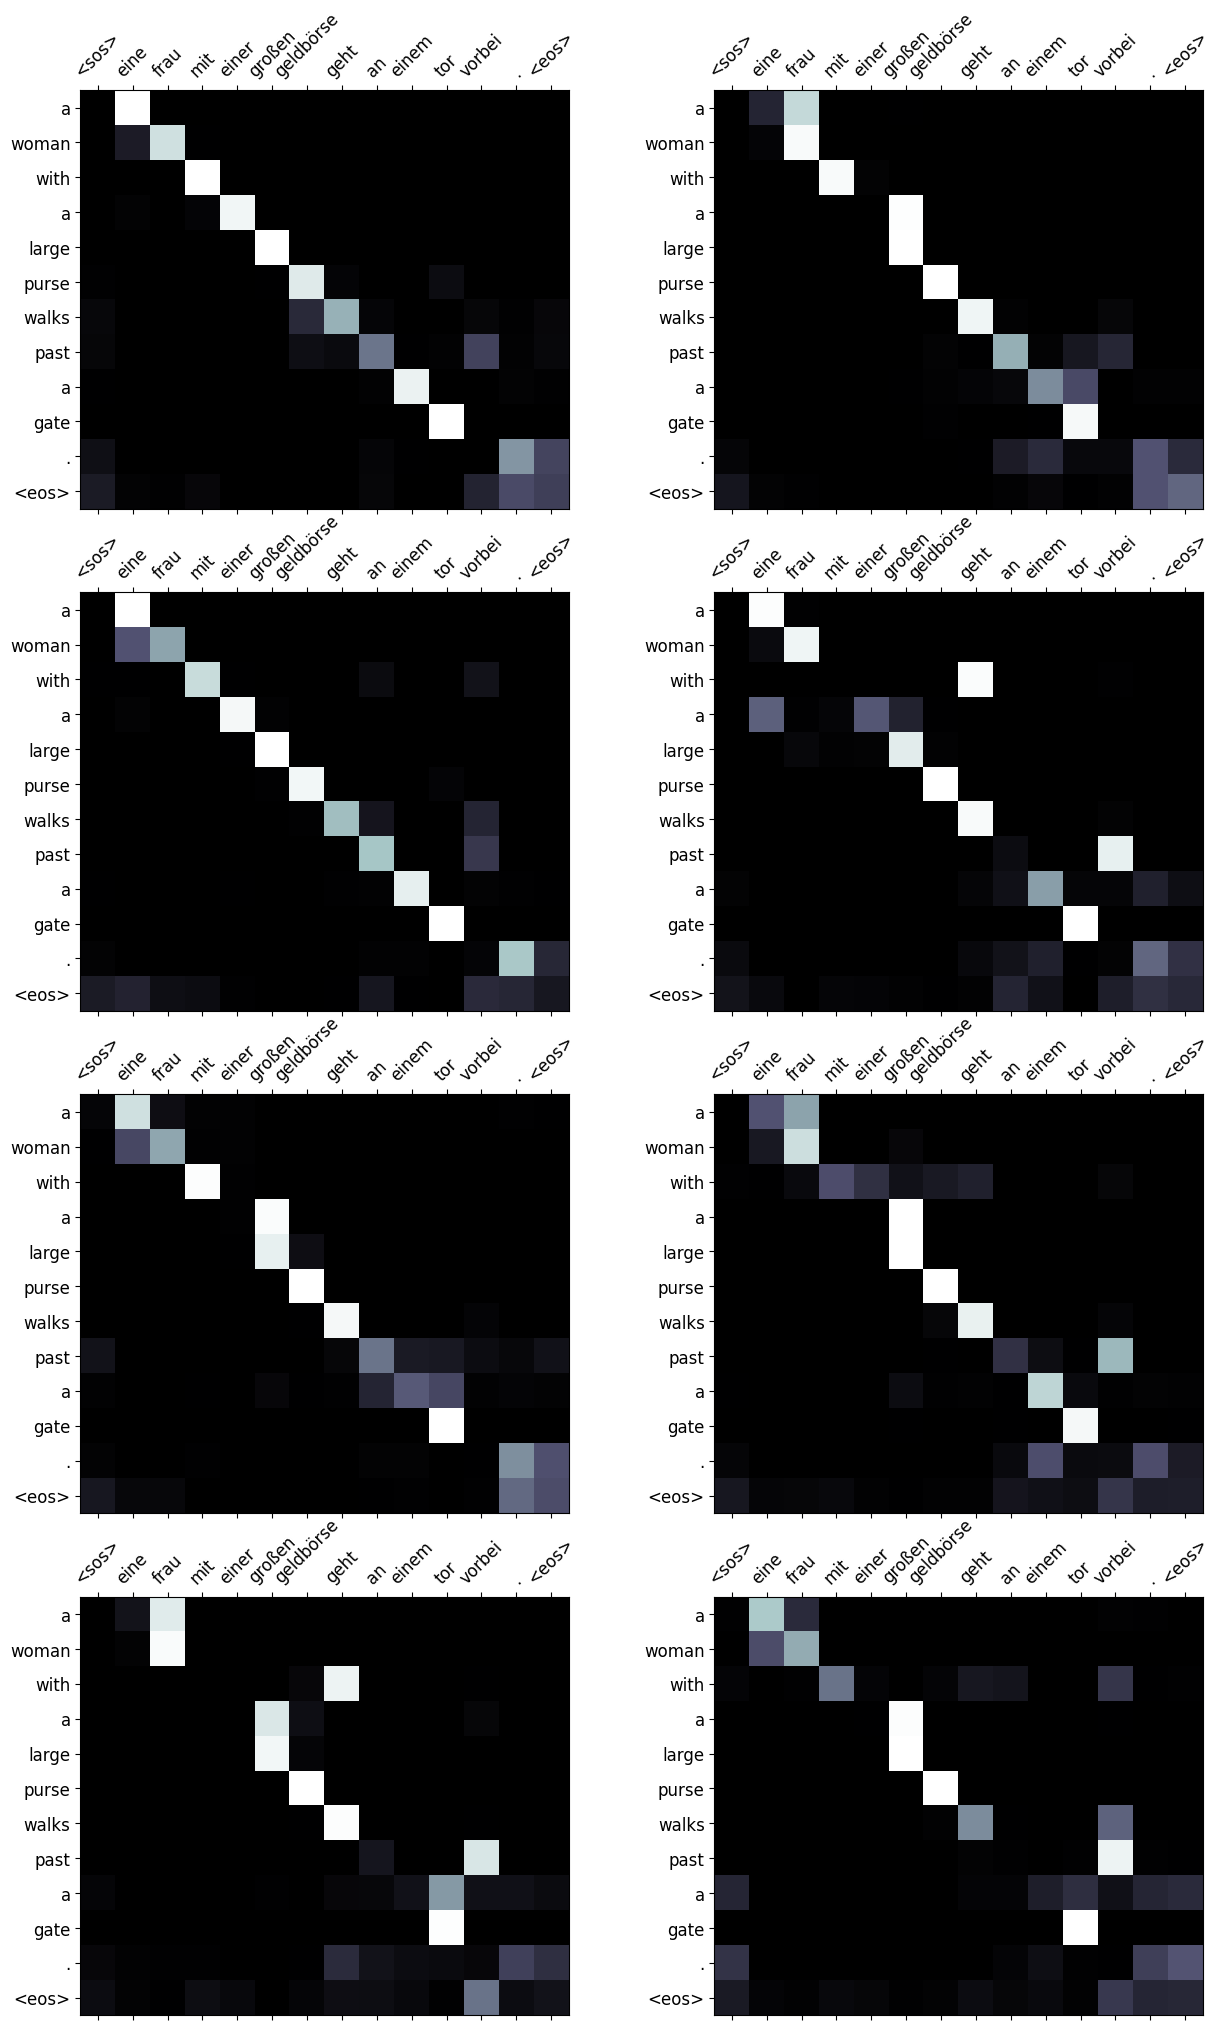

In [104]:
display_attention(src, translation, attention)

In [105]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


src = ['ein', 'kleiner', 'junge', 'mit', 'einem', 'giants-trikot', 'schwingt', 'einen', 'baseballschläger', 'in', 'richtung', 'eines', 'ankommenden', 'balls', '.']
trg = ['a', 'young', 'boy', 'wearing', 'a', 'giants', 'jersey', 'swings', 'a', 'baseball', 'bat', 'at', 'an', 'incoming', 'pitch', '.']


In [106]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'boy', 'in', 'a', 'baseball', 'cap', 'swings', 'a', 'baseball', 'bat', 'in', 'a', 'baseball', 'uniform', 'swings', 'at', 'an', 'attempt', 'to', 'take', 'a', 'ball', '.', '<eos>']


In [107]:
with tick.marks(50):        
    assert compare_lists_by_percentage(trg, translation, 30)

AssertionError: 

Una vez más, algunas cabezas prestan toda su atención a "ein", mientras que otras no le prestan atención. Una vez más, la mayoría de los heads parecen extender su atención sobre los tokens de punto y <eos> en la oración de origen cuando emiten el punto y la oración <eos> en la oración de destino predicha, aunque algunos parecen prestar atención a los tokens cerca del comienzo de la oración.

/tmp/ipykernel_184/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_184/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


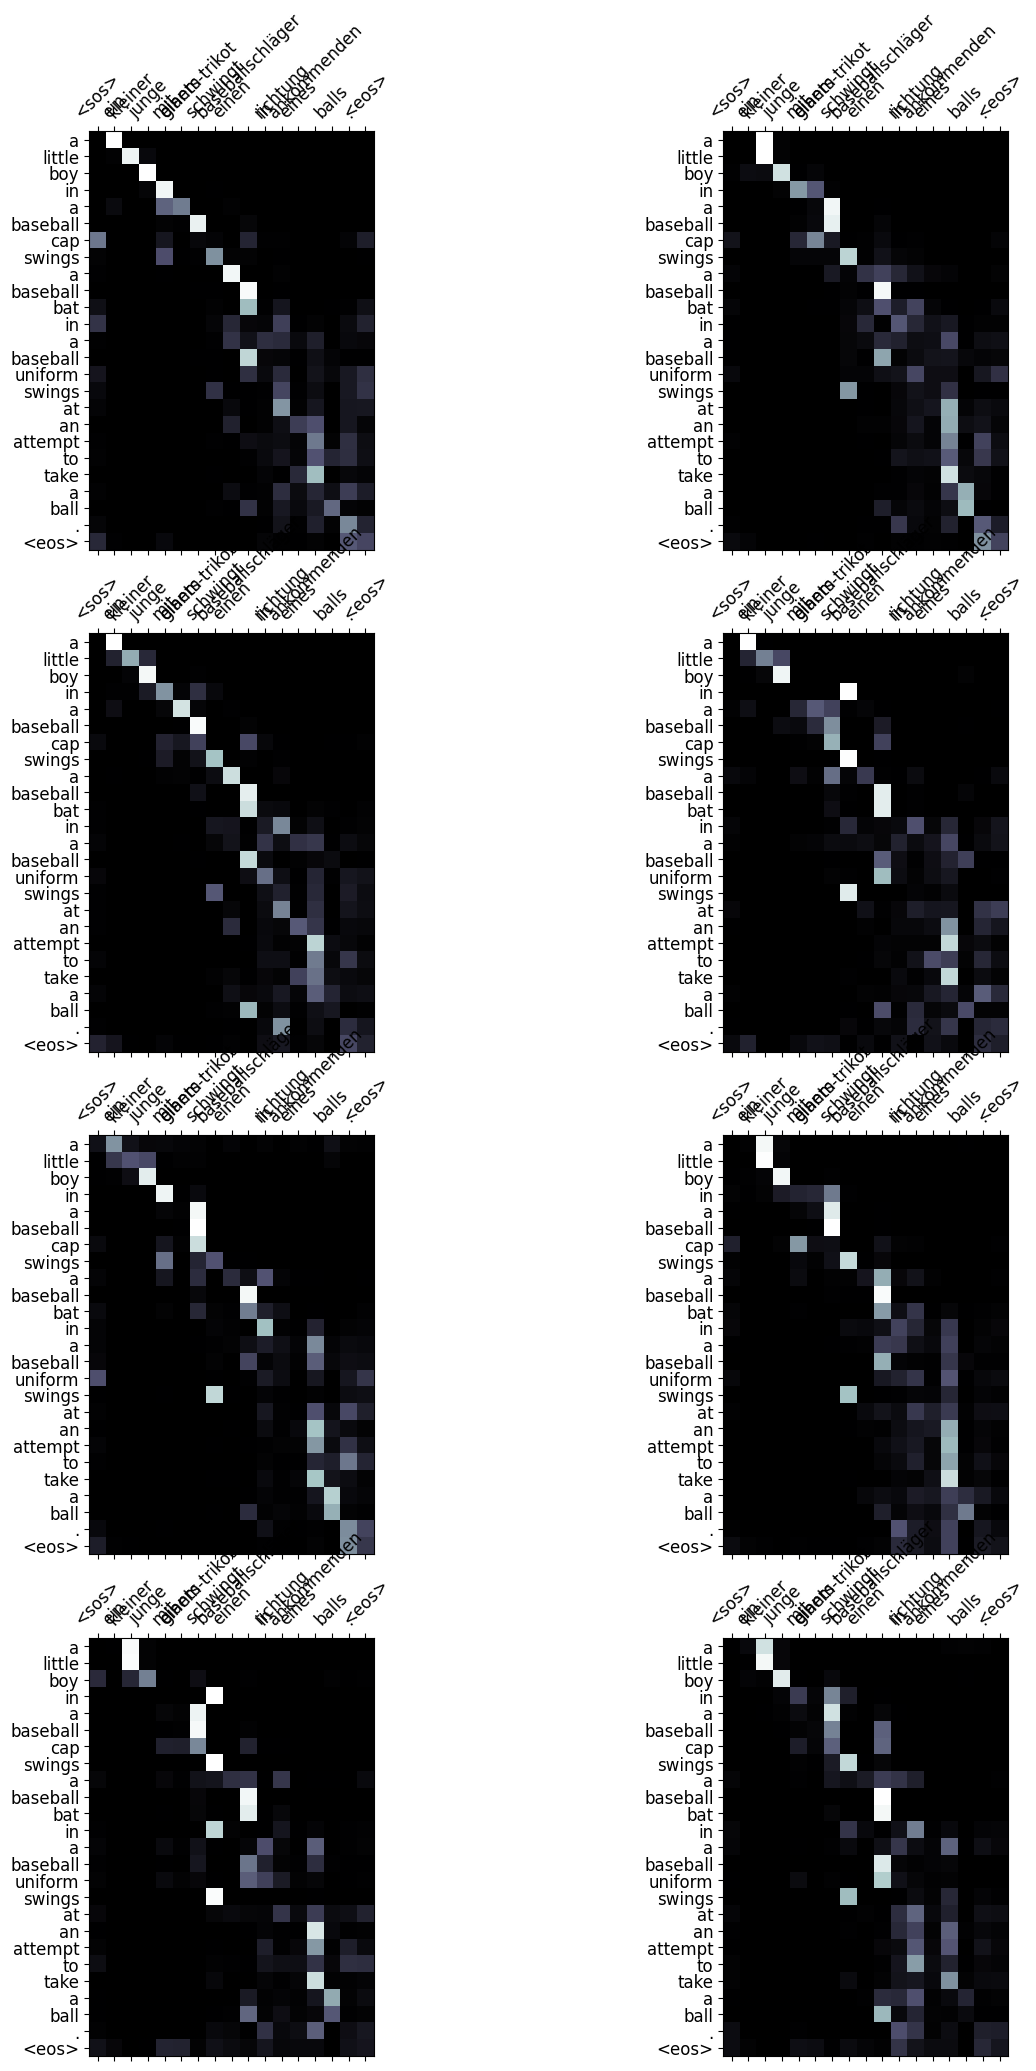

In [108]:
display_attention(src, translation, attention)

In [109]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [110]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'are', 'enjoying', 'a', 'beautiful', 'day', '.', '<eos>']


In [111]:
with tick.marks(50):        
    assert compare_lists_by_percentage(trg, translation, 33.2)

/tmp/ipykernel_184/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_184/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


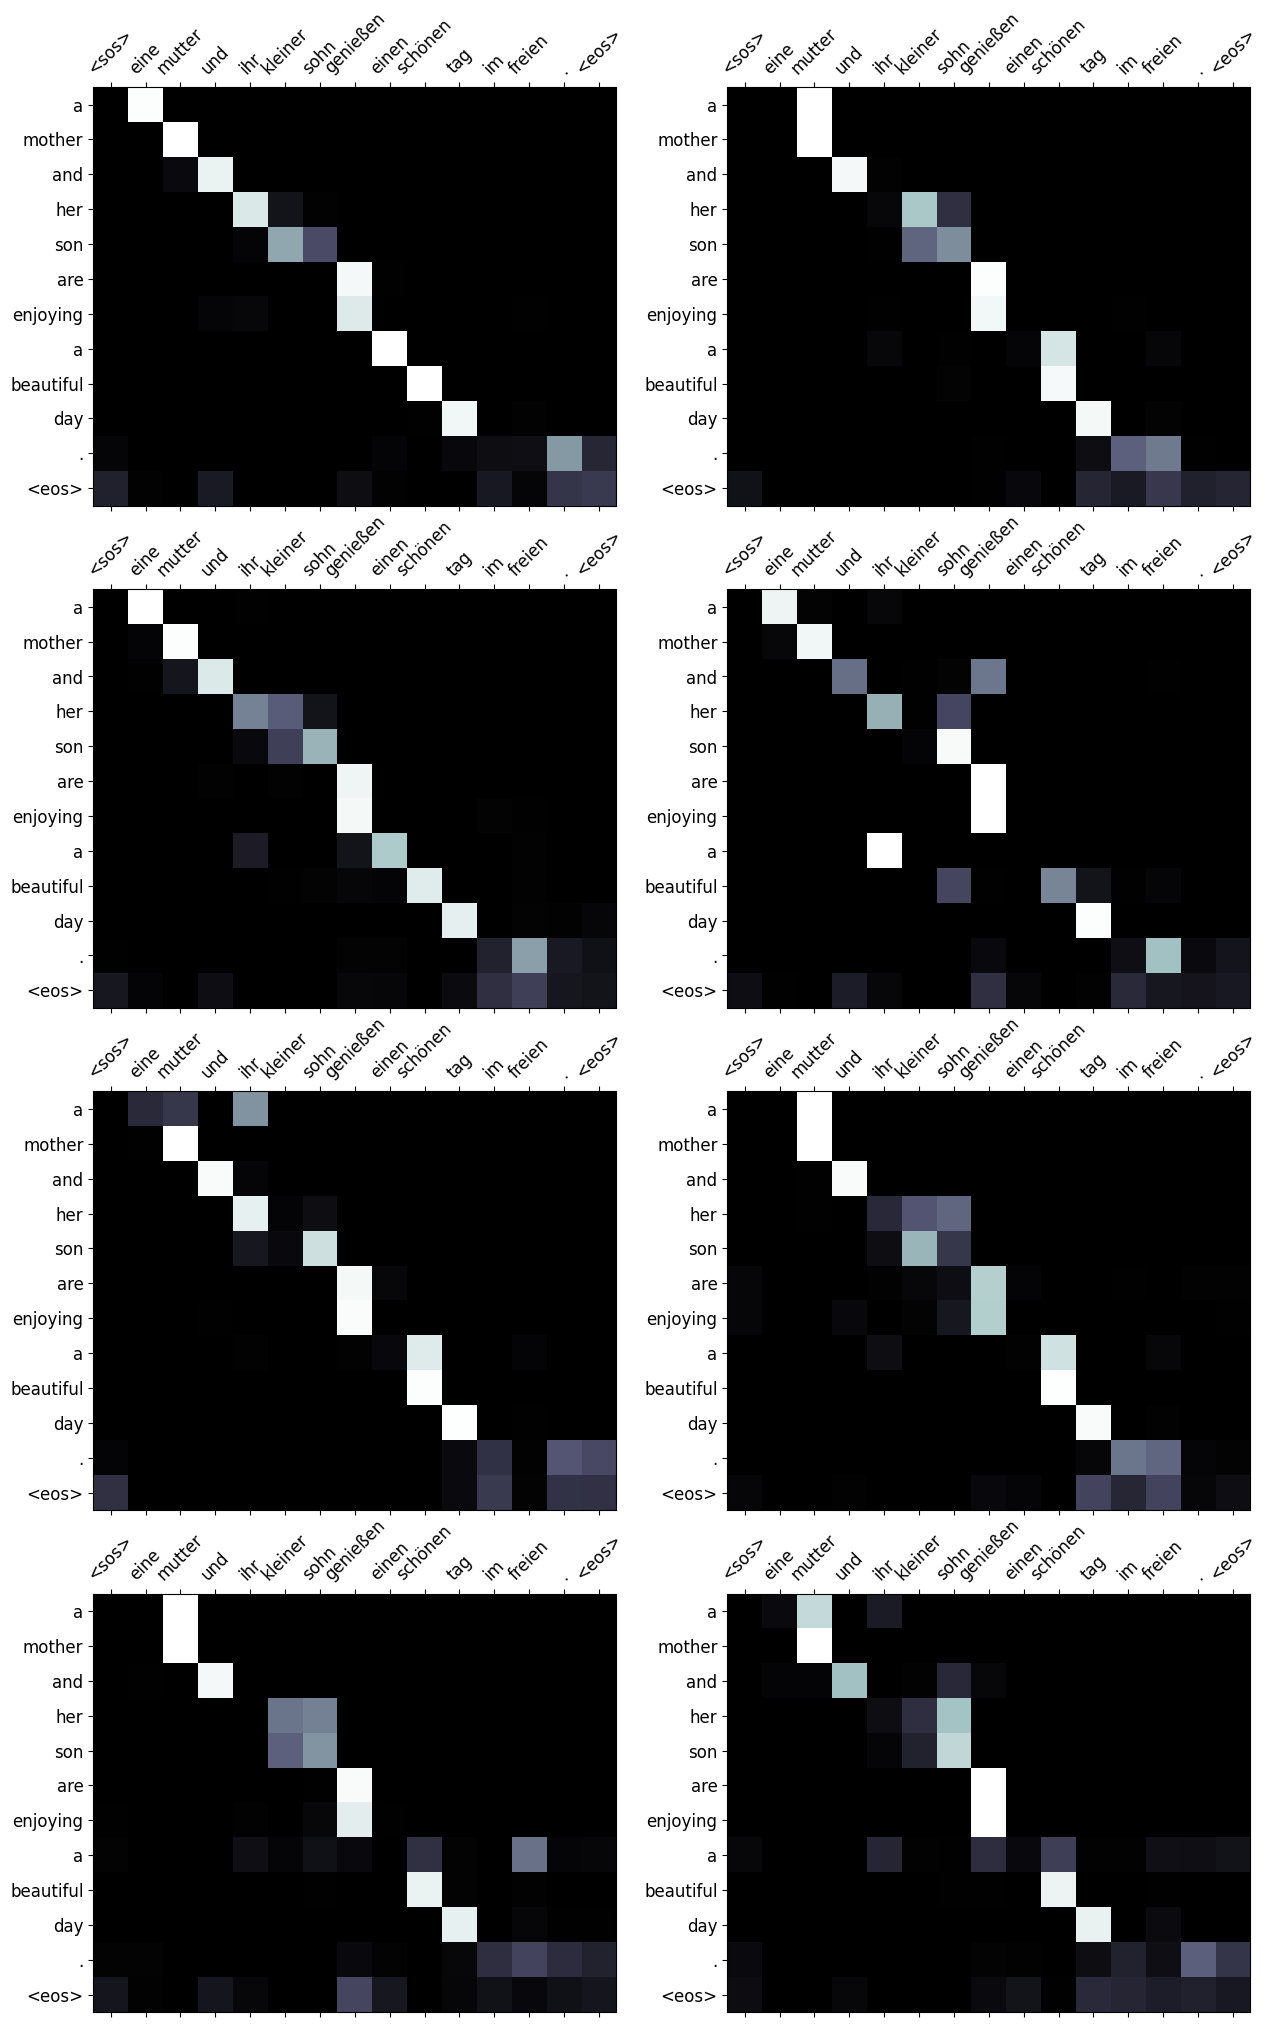

In [112]:
display_attention(src, translation, attention)

Calculamos el score BLEU

**NB:** El score BLEU (Bilingual Evaluation Understudy) es una métrica para evaluar la calidad de las traducciones generadas por máquinas en comparación con referencias humanas. Mide la superposición de secuencias de n-gramas entre la traducción generada por la máquina y las traducciones de referencia. BLEU calcula la precisión contando los n-gramas coincidentes y también aplica una penalización por brevedad para fomentar traducciones más largas. Produce un puntaje entre 0 y 1, siendo puntajes más altos indicativos de una mejor calidad de traducción, aunque no captura todas las sutilezas de la calidad de la traducción.

In [113]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [114]:
bleu_score_ = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score_*100:.2f}')

BLEU score = 35.63


In [115]:
with tick.marks(50):        
    assert compare_numbers(new_representation(bleu_score_), "3e3d", '0x1.5c28f5c28f5c3p-2')

**PREGUNTAS:** Responda las siguintes preguntas en este espacio (10% de la nota)
* ¿Cómo afecta la cantidad de parámetros del modelo? ¿Qué nos dicen eso 9M de parametros del modelo que hemos creado?
* ¿Qué hace el algoritmo de inicialización de Xavier Uniform?
* ¿Qué hace el comando torch.no_grad()?
* Interprete el valor obtenido para el BLEU score ¿es nuestro modelo un buen modelo?
* ¿Qué puede observar de las palabras donde el modelo se ha confundido?
* Observe el comportamiento de la pérdida y PPL en training y validation mientras se entrega el modelo, ¿qué puede decir de estos valores?
* Si bien no es una tarea intuitiva o sencilla la interpretación de las gráficas de attention que hemos realizado, intente darle una interpretación a la última de estas gráficas mostrada. ¿Qué tipo de insights podría sacar de esta gráfica?

In [117]:
**PREGUNTAS:** Responda las siguintes preguntas en este espacio (10% de la nota)
* ¿Cómo afecta la cantidad de parámetros del modelo? ¿Qué nos dicen eso 9M de parametros del modelo que hemos creado?
La cantidad de parámetros es una medida directa sobre su capacidad para aprender y considerar complejidades. 
Los 9M de parametros indican que tiene una capacidad moderada para aprender, adecuada para la traducción. 
* ¿Qué hace el algoritmo de inicialización de Xavier Uniform?
La inicialización Xavier Uniform es un método utilizado para inicializar los pesos de las redes neuronales de manera que se mantenga la varianza de las activaciones a través de las capas, lo que ayuda a prevenir problemas como el desvanecimiento o explosión de gradientes. 
Xavier Uniform distribuye los pesos de manera uniforme dentro de un rango determinado por el número de unidades de entrada y salida de cada capa, mejorando la convergencia durante el entrenamiento.
* ¿Qué hace el comando torch.no_grad()?
Desactiva el calculo de gradientes durante la fase de inferencia o validación. Esto reduce el consumo de memoria y mejora la eficiencia.
* Interprete el valor obtenido para el BLEU score ¿es nuestro modelo un buen modelo?
Como se encuentra entre 0.3 y 0.5 (en el print fue multiplicado por 100) es considerado moderadamente bueno. No es excelente, pero cumple su función.
* ¿Qué puede observar de las palabras donde el modelo se ha confundido?

* Observe el comportamiento de la pérdida y PPL en training y validation mientras se entrega el modelo, ¿qué puede decir de estos valores?
* Si bien no es una tarea intuitiva o sencilla la interpretación de las gráficas de attention que hemos realizado, intente darle una interpretación a la última de estas gráficas mostrada. ¿Qué tipo de insights podría sacar de esta gráfica?

SyntaxError: invalid syntax (223239111.py, line 1)

In [116]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 


La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
